In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy import stats

from pathlib import Path
import sys

PATH = '/Users/danil/Documents/github/Klarna/'
sys.path.append(str(PATH))

In [3]:
%%time

events = pd.read_csv(PATH + 'data/raw/events.csv')

CPU times: user 953 ms, sys: 214 ms, total: 1.17 s
Wall time: 1.25 s


convert timestamp to datetime format

In [3]:
events['timestamp'] = events['timestamp'].apply(
    lambda x: datetime.datetime.fromtimestamp(x//1000.0))

print(events.shape)
events.head()

(2756101, 5)


,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 08:02:12,257597,view,355908,NaN
1,2015-06-02 08:50:14,992329,view,248676,NaN
2,2015-06-02 08:13:19,111016,view,318965,NaN
3,2015-06-02 08:12:35,483717,view,253185,NaN
4,2015-06-02 08:02:17,951259,view,367447,NaN


In [4]:
print('events from', events['timestamp'].min(),
      '\nevents to', events['timestamp'].max())

events from 2015-05-03 06:00:04 
events to 2015-09-18 05:59:47


drop september data

In [5]:
events = events[events['timestamp'] <= '2015-09-01']
print(events.shape)

(2448866, 5)


# user activety

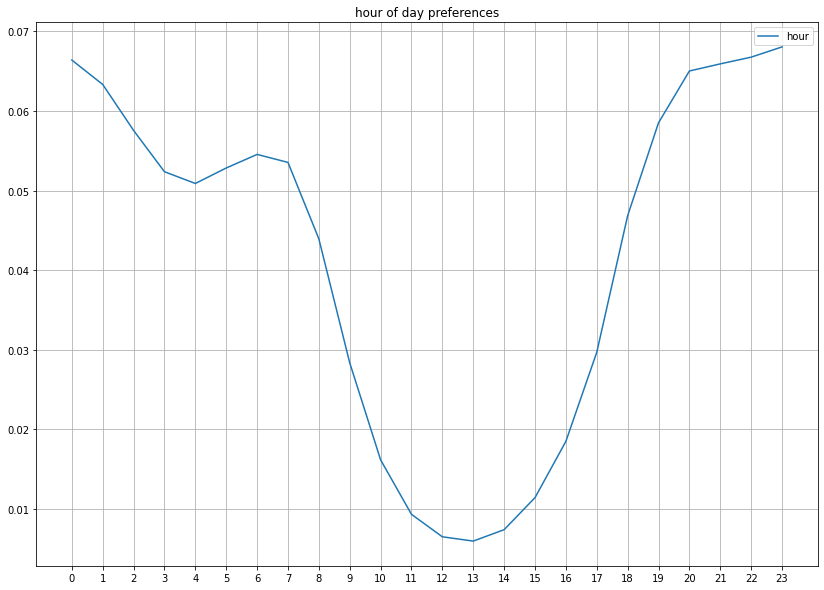

In [65]:
events['hour'] = events['timestamp'].dt.hour

active_hours = events['hour'].value_counts().sort_index()/events.shape[0]
hours_df = pd.DataFrame(active_hours)

ax = hours_df.plot(figsize=(14, 10), grid=True)
ax.set_xticks(range(len(hours_df)))
ax.set_title('hour of day preferences')

as we can see, most activity became in the evening (from 20 till 02)and early morning (from 5 till 7) or it is just means that we have datetime from different time zones

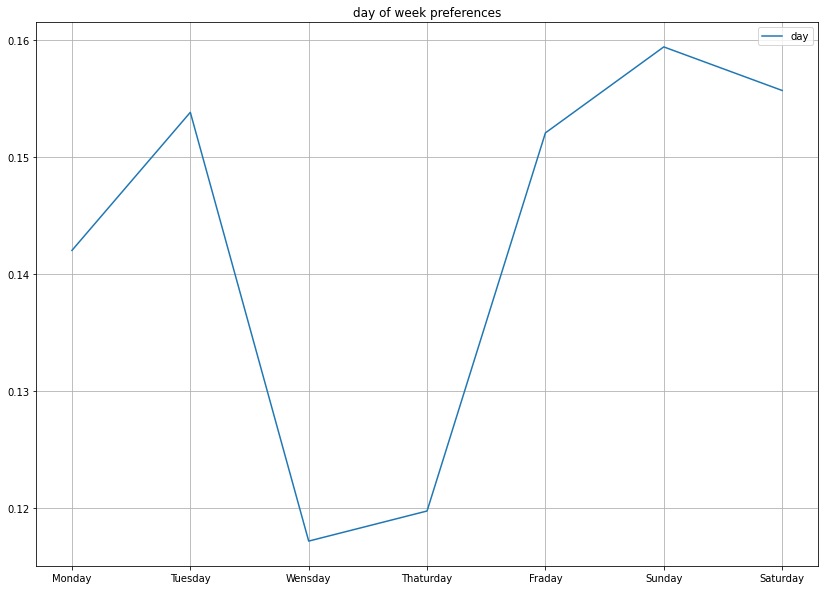

In [60]:
events['day'] = events['timestamp'].dt.day_name()

active_days = events['day'].value_counts().sort_index()/events.shape[0]
days_df = pd.DataFrame(active_days)

days = pd.Series(['Monday', 'Tuesday', 'Wensday',
                  'Thaturday', 'Fraday', 'Sunday', 'Saturday'])
ax = days_df.plot(figsize=(14, 10), grid=True)
ax.set_xticks(range(len(days)))
ax.set_xticklabels(days)
ax.set_title('day of week preferences')

here we see that weekends have most activity. Wednesday and Thaturday have lowest activity? bu diff in 0.04%

In [66]:
events = events.drop(['day', 'hour'], 1)

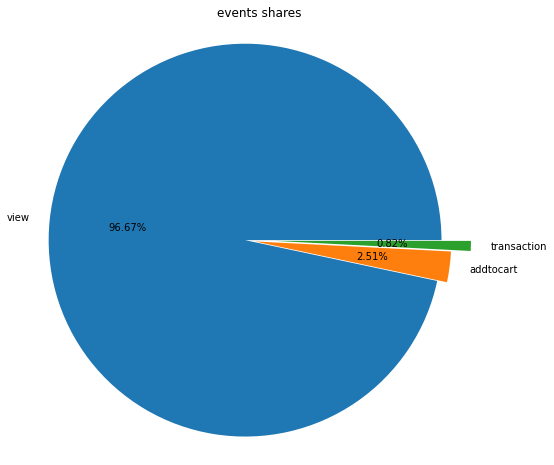

In [8]:
data = events.event.value_counts()
labels = data.index
sizes = data.values
explode = (0, 0.05, 0.15)
fig, ax = plt.subplots(figsize=(8, 8))

patches, texts, autotexts = ax.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%',
                                   shadow=False, startangle=0)

ax.axis('equal')
plt.title('events shares')
plt.show()

# users analysis

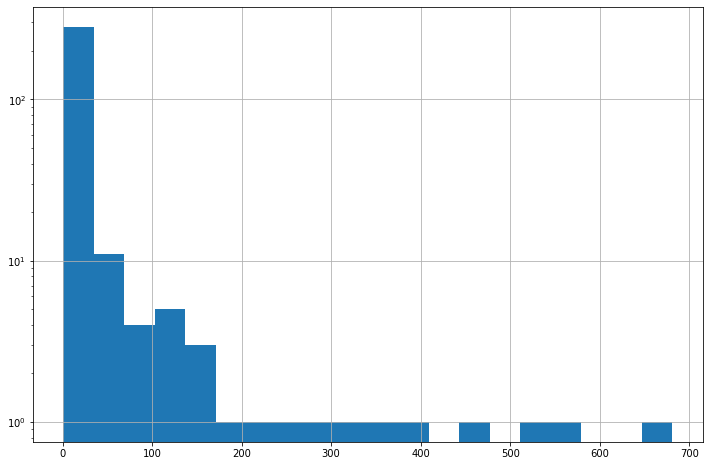

In [204]:
visitor_count = events['visitorid'].value_counts().value_counts()

quantile_95 = visitor_count.quantile(.95)

visitor_count[visitor_count <= quantile_95].hist(
    bins=20, log=True, figsize=(12, 8))

we can see some increasing of users activity after 100 interaction, but better to provide cohort analysis

In [123]:
(visitor_count/events.shape[0])[:5]

1    0.363381
2    0.074223
3    0.028706
4    0.014016
5    0.008345
Name: visitorid, dtype: float64

36% of actions became on users that made 1 action 

In [127]:
users_action = events.groupby('visitorid')['event'].apply(set)

users_action = users_action.reset_index()

In [138]:
active_users_num = users_action[users_action['event'] != {'view'}].shape[0]
print('total users number :', users_action.shape[0],
      '\nusers with not only view action:', active_users_num,
      '\nactive users share:', active_users_num/users_action.shape[0])

total users number : 1249059 
users with not only view action: 34543 
active users share: 0.027655218848749337


wow, only 2.7% users made some actions

In [151]:
purchase_users_num = users_action[users_action['event'] == {
    'addtocart', 'view', 'transaction'}].shape[0]
print('active users number :', active_users_num,
      '\nusers with transaction action:', purchase_users_num,
      '\npurchse users share:', purchase_users_num/active_users_num)

active users number : 34543 
users with transaction action: 9180 
purchse users share: 0.2657557247488637


In [154]:
print('share of users with transecation:',
      purchase_users_num/users_action.shape[0])

share of users with transecation: 0.007349532728237817


and 26% users made purchase from users who add to cart, it means that 0.735% users who once made purchase

Lets check how much views falls on every transaction

In [328]:
purchase_users = users_action[users_action['event'] == {'addtocart', 'view', 'transaction'}]['visitorid']

In [330]:
purchase_users_actions = events[events['visitorid'].isin(purchase_users)].groupby(['visitorid', 'event'])['event'].count()

In [340]:
purchase_users_actions = purchase_users_actions.reset_index(
    name='count').set_index(["event", "visitorid"]).unstack(level=0)

purchase_users_actions.columns = ['addtocart', 'transaction', 'view']

purchase_users_actions = purchase_users_actions.reset_index()

purchase_users_actions = purchase_users_actions.eval(
    'veiw_purch_ratio = transaction / view')

In [344]:
print(purchase_users_actions.shape)
purchase_users_actions.head()

(9180, 5)


,visitorid,addtocart,transaction,view,veiw_purch_ratio
0,172,3,2,33,0.060606
1,186,1,1,2,0.500000
2,419,1,1,4,0.250000
3,539,2,1,4,0.250000
4,627,1,1,17,0.058824


here I made dataframe with number of actions for every user (who made transaction)

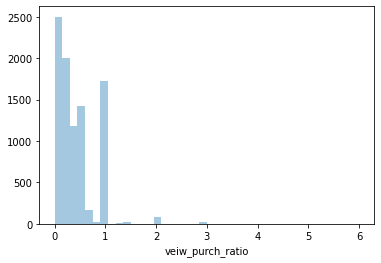

In [195]:
sns.distplot(purchase_users_actions['veiw_purch_ratio'], bins=40, kde=False)

veiw_purch_ratio it is ratio between view actions and purchase actions, shown how much average user make views before he made 1 transaction

interesting but we can see that some users made more purchases that check items, maybe this is fraud or very rich users)))

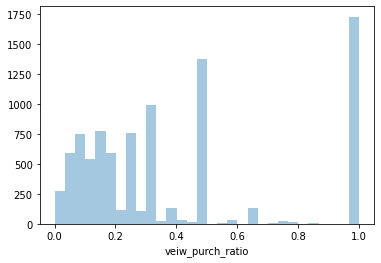

In [194]:
sns.distplot(purchase_users_actions[purchase_users_actions['veiw_purch_ratio'] <= 1]['veiw_purch_ratio'],
             kde=False)

need to check what is the category of items that was purchased by users who have veiw_purch_ratio == 1

In [198]:
purchase_users_actions[purchase_users_actions['veiw_purch_ratio'] <= 1]['veiw_purch_ratio'].median()

0.3120567375886525

median value for this ration is 0.31, it means that usually for every 3 views, users (who made purchase) made 1 purchase. but this is not normal distribution, so this measure very rough

In [347]:
events['date'] = events['timestamp'].dt.date

Now I want to check difference between activity of loyal (who made purchse) and unloyal (without purchases) users

In [373]:
active_days = events[~events['visitorid'].isin(purchase_users)].groupby('visitorid')['date'].nunique()
active_days_loyal_users = events[events['visitorid'].isin(purchase_users)].groupby('visitorid')['date'].nunique()

In [374]:
from scipy import stats


def median_confident_interval(data: pd.Series, ci: float = .95, p=.5) -> list:
    '''
    calc CI for median

    params:
    -------------
    data 

    ci: float - confident interval

    p: float - percentile


    list with boundaries
    '''

    data = data.values

    data = data.reshape(-1)
    data = np.sort(data)
    N = data.shape[0]

    lowCount, upCount = stats.binom.interval(ci, N, p, loc=0)
    lowCount -= 1
    return data[int(lowCount)], data[int(upCount)]

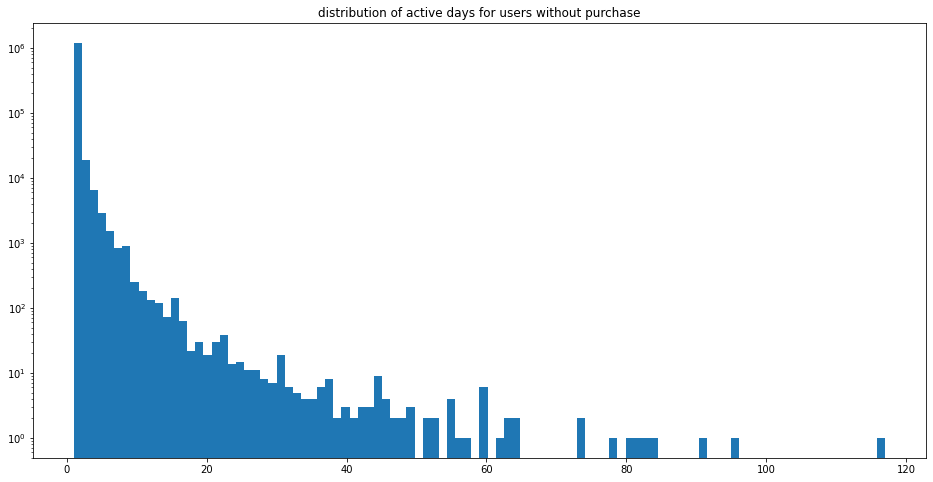

In [382]:
active_days.hist(bins=100, figsize=(16, 8), grid=False, log=True).set_title(
    'distribution of active days for users without purchase')

In [376]:
median_confident_interval(active_days)

(1, 1)

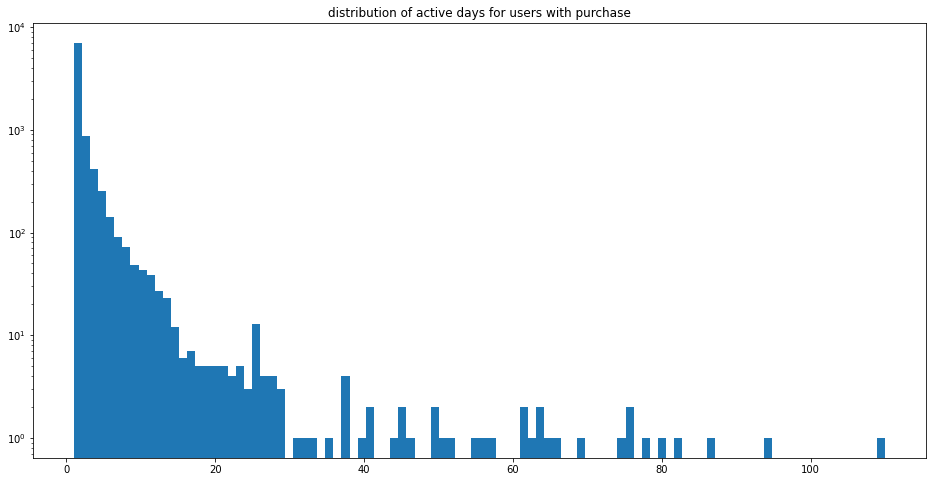

In [383]:
active_days_loyal_users.hist(bins=100, figsize=(16, 8), grid=False, log=True).set_title(
    'distribution of active days for users with purchase')

In [378]:
median_confident_interval(active_days_loyal_users)

(1, 1)

both confident intervals shows the same result and from distibutions I cant see differencies between users who made some transactions and others, unfortunately we cant distinguish users who will made purchase from others by number of active days

# item analysis

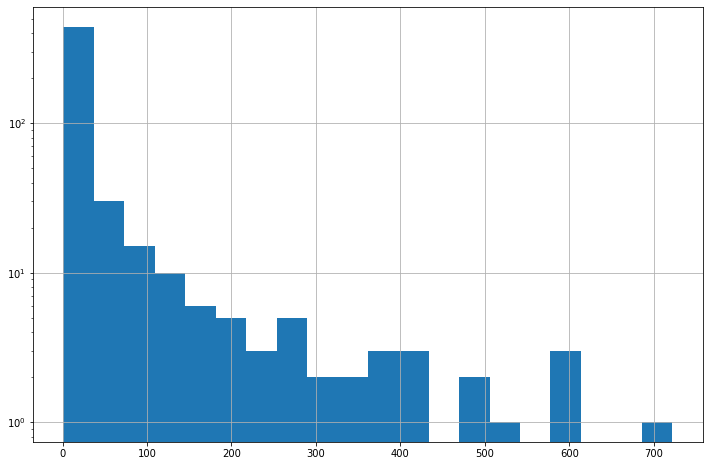

In [206]:
itemid_count = events['itemid'].value_counts().value_counts()

quantile_95 = itemid_count.quantile(.95)

itemid_count[itemid_count <= quantile_95].hist(
    bins=20, log=True, figsize=(12, 8))

In [207]:
(itemid_count/events.shape[0])[:5]

1    0.029250
2    0.013634
3    0.008246
4    0.005646
5    0.004090
Name: itemid, dtype: float64

only 2.9% of items was viewed (or made anly transaction) once

In [209]:
active_items = events.groupby('itemid')['event'].apply(set).reset_index()

In [210]:
purchased_items = events[events['event'] == 'transaction']['itemid'].unique()

In [213]:
print('active items num :', active_items.shape[0], '\npurchased items :', len(purchased_items),
      '\nshare of purchased items :', len(purchased_items)/active_items.shape[0])

active items num : 222840 
purchased items : 10995 
share of purchased items : 0.0493403338718363


only 5% of items was bought at least once

In [218]:
events[events['itemid'].isin(purchased_items)].groupby('itemid')['event'].count().sort_values(ascending=False).head()

itemid
461686    2393
257040    1642
309778    1623
219512    1531
384302    1352
Name: event, dtype: int64

most popular items for view and once be purchased

In [219]:
events[~events['itemid'].isin(purchased_items)].groupby('itemid')['event'].count().sort_values(ascending=False).head()

itemid
187946    2689
5411      2173
370653    1732
298009    1535
96924     1419
Name: event, dtype: int64

most popular items for view and was not purchased, for future it might be interesting to check why, maybe image doesnt correspond to item

In [386]:
top_5_items = events[~events['itemid'].isin(purchased_items)].groupby('itemid')['event'].count().sort_values(ascending=False)[:5].index


In [388]:
events.head()

,timestamp,visitorid,event,itemid,transactionid,date
0,2015-06-02 08:02:12,257597,view,355908,NaN,2015-06-02
1,2015-06-02 08:50:14,992329,view,248676,NaN,2015-06-02
2,2015-06-02 08:13:19,111016,view,318965,NaN,2015-06-02
3,2015-06-02 08:12:35,483717,view,253185,NaN,2015-06-02
4,2015-06-02 08:02:17,951259,view,367447,NaN,2015-06-02


In [412]:
items_per_day = events[events['itemid'].isin(top_5_items)].groupby(['itemid', 'date'])['event'].count().reset_index()

items_per_day = items_per_day.pivot(index='date', columns='itemid', values='event').reset_index().set_index('date')


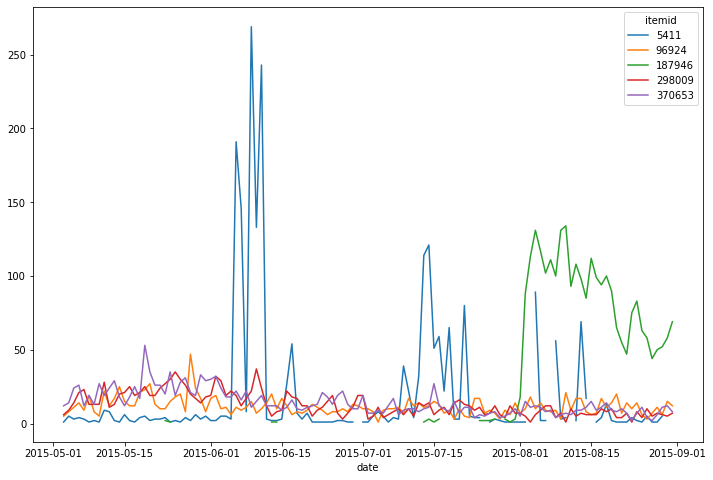

In [413]:
items_per_day.plot(figsize=(12, 8));

here we can see number of events with most popular items

96924, 370653, 298009 always popular (this criteria can help to find pretty good recommendations for cold users)

187946 gained popularity just recently

5411 - has some peaks at different periods of time

# item features

In [221]:
%%time

items1 = pd.read_csv(PATH + 'data/raw/item_properties_part1.csv')
items2 = pd.read_csv(PATH + 'data/raw/item_properties_part2.csv')
items = pd.concat([items1, items2])

items.head()

CPU times: user 12.9 s, sys: 3.09 s, total: 16 s
Wall time: 17.5 s


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [279]:
items['timestamp'] = items['timestamp'].apply(
    lambda x: datetime.datetime.fromtimestamp(x//1000.0))

drop september data

In [280]:
items = items[items['timestamp'] <= '2015-09-01']
print(events.shape)

(2448866, 5)


In [281]:
items = items.sort_values('timestamp')

here I found all properties that have only numeric values

In [283]:
num_prop = (
    items.groupby('property')['value']
    .apply(lambda x: (x.str.startswith('n').all()) & (~x.str.contains(' ').all()))
    .to_frame('num_prop')).reset_index()

num_prop_list = num_prop[num_prop['num_prop'] == 1]['property']

print(len(num_prop_list))
num_prop_list

34


9       1005
83      1072
94      1082
115     1100
163      150
176      162
195       18
222      203
231      211
238      218
242      221
260      239
263      241
268      246
278      255
315      289
405       37
418      381
426      389
529      482
685      622
689      626
715      650
741      674
744      677
753      685
774      703
870      790
959      870
963      874
971      881
1018     923
1040     943
1065     967
Name: property, dtype: object

I wanted to make embedding vector for every item with property values, but later I found that some of numeric properties have very few records

It means that we can try found closest item to recom only from the same category

In [284]:
item_cat = items[items['property'] == 'categoryid'][['itemid', 'value']].drop_duplicates(keep = 'last')

I will use last defined categoryid 

In [294]:
item_last_cat = item_cat.groupby('itemid')['value'].apply(lambda x: x.iloc[-1])

now 1 item has 1 category

In [305]:
item_last_cat = item_last_cat.to_frame(name='category').reset_index()

In [308]:
cat_tree_df = pd.read_csv(PATH + 'data/raw/category_tree.csv')

In [313]:
cat_tree_dict = {v['categoryid']: v['parentid']
                 for _, v in cat_tree_df.iterrows()}

In [326]:
main_cats = [i for i in cat_tree_dict if np.isnan(cat_tree_dict[i])]

In [415]:
main_cats

[231.0,
 791.0,
 1490.0,
 431.0,
 755.0,
 378.0,
 1579.0,
 1394.0,
 659.0,
 1057.0,
 859.0,
 803.0,
 250.0,
 1452.0,
 1182.0,
 1692.0,
 1600.0,
 1482.0,
 1224.0,
 1532.0,
 395.0,
 653.0,
 140.0,
 1698.0,
 679.0]

# future steps
1. find most popular categories
2. check if we could find preffered user category
3. separate items to groups that always popular, seasonal, recent trend
4. cohort analysis